### ESBM for recommender systems

LAST FULL RUN 30/04 12:31

In [18]:
#!uv pip install -q --system numba-cuda==0.4.0

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
from collections import OrderedDict
from scipy.special import gamma
import scipy.special as sc
import numba as nb
from scipy.special import gammaln
import time
import seaborn as sns
from math import lgamma
from numba import cuda
from scipy.stats import mode
from functs2 import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

In [20]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows")

In [21]:
# from numba import config
# config.CUDA_ENABLE_PYNVJITLINK = 1

In [22]:
# implement cov processing
n_users = 200
n_items = 200
n_cl_u = 5
n_cl_i = 8

np.random.seed(2)
user_clustering = list(np.random.choice([0,1,2,3], p=[0.6, 0.2, 0.15, 0.05],size=n_users))
t = np.array([1 if user_clustering[i]%2==0 else 0 for i in range(n_users)])
t[np.random.randint(0, len(t), size=25)] = 0
cov_users = [('gender_cat', t.copy())]

item_clustering = list(np.random.choice([0,1,2,3], p=[0.5, 0.25, 0.2, 0.05],size=n_users))
t3 = np.array([1 if item_clustering[i]%2==0 else 0 for i in range(n_items)])
t3[np.random.randint(0, len(t3), size=25)] = 0
cov_items = [('genre_cat', t3.copy()) for _ in range(1)]

theta = np.array([
    [0.1, 1.5, 0.1, 1.5],
    [1.5, 0.1, 1.5, 0.1],
    [0.1, 1.5, 0.1, 1.5],
    [1.5, 0.1, 1.5, 0.1],
    ])

params = {
    'num_users':n_users,
    'num_items': n_items,
    'user_clustering':'random',
    'item_clustering':'random',
    'user_clustering':user_clustering,
    'item_clustering':item_clustering,
    #'theta':theta,
    'prior_a':1,
    'prior_b':1,
    'seed':1,
    'scheme_type':'DM',
    'scheme_param':1,
    'bar_h_users':5,
    'bar_h_items':5,
    'sigma':-0.9,
    'epsilon':1e-30,
    'gamma':0.9,
    # 'degree_param_users':10000000,
    # 'degree_param_items':10000000,
    'cov_users':cov_users,
    'cov_items':cov_items,
    'alpha_c':[1.5, 1.5, 1.5,1.5, 1.5],
}

model = esbm(**params)

compute_log_likelihood(nh = model.frequencies_users, nk = model.frequencies_items, a = model.prior_a, 
                             b = model.prior_b, eps = model.epsilon, mhk=model.compute_mhk(), 
                             user_clustering=model.user_clustering, 
                             item_clustering=model.item_clustering,
                             degree_param_users=1,
                             degree_param_items=1,
                             dg_u=np.zeros(model.num_users), 
                             dg_i=np.zeros(model.num_items), 
                             dg_cl_i=np.zeros(model.n_clusters_items), 
                             dg_cl_u=np.zeros(model.n_clusters_users),
                             degree_corrected=False)

randomly initialising data


-26675.056302494864

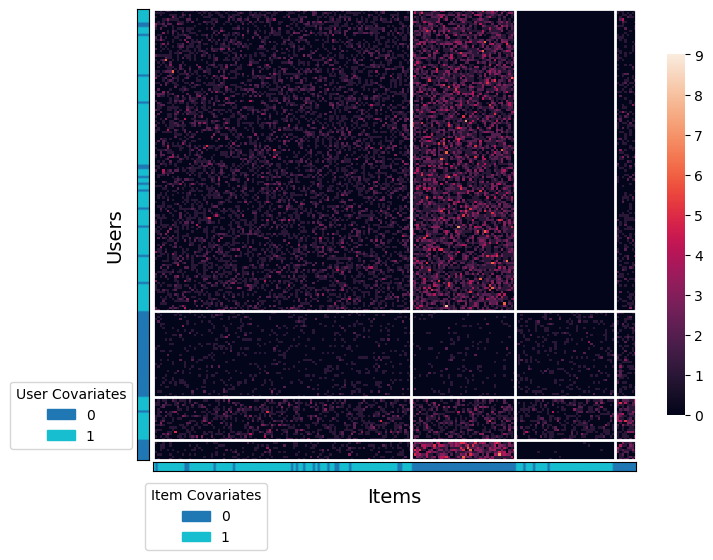

In [23]:
plot_heatmap(model, size=(8,6), user_covariates = model.cov_values_users[0], item_covariates=model.cov_values_items[0], add_labels=False)

### Generate validation set

In [24]:
def generate_val_set(y, size=0.1, seed=42, only_observed=True):
    np.random.seed(seed)
    n_users, n_items = y.shape
    n_val = int(size*n_users*n_items)
    y_val = []
    for _ in range(n_val):
        u = np.random.randint(n_users)
        i = np.random.randint(n_items)
        if only_observed:
            while y[u,i] == 0:
                u = np.random.randint(n_users)
                i = np.random.randint(n_items)
        y_val.append((u,i, int(y[u,i])))
    
    y_train = y.copy()
    for u,i, _ in y_val:
        y_train[u,i] = 0
    
    return y_train, y_val

In [25]:
Y_train, Y_val = generate_val_set(model.Y, size=0.2, seed=42, only_observed=False)

In [26]:
np.save('train_dt_esbm.npy', Y_train)
np.save('val_dt_esbm.npy', Y_val)
np.save('full_dt_esbm.npy', model.Y)

In [27]:
Y_train.shape

(200, 200)

In [28]:
def validate_models(Y_train, Y_val, model_list, param_list, n_iters=500, burn_in=None, verbose=0,
                    thinning=3, model_names=None, true_users=None, true_items=None, k=None,
                    print_intermid=False):
    if burn_in is None:
        burn_in = n_iters//2
    
    Y_val_pairs = [(u,i) for u,i,_ in Y_val]
    Y_val_users = [u for u,_,_ in Y_val]
    Y_val_items = [i for _,i,_ in Y_val]
    Y_val_ratings = [r for _,_,r in Y_val]
    
    
    val_users_relevant = {}

    for j in range(len(Y_val_pairs)):
        u = Y_val_users[j]
        i = Y_val_items[j]
        r = Y_val_ratings[j]
        if u not in val_users_relevant:
            val_users_relevant[u] = [] 
        if r > 1:
            val_users_relevant[u].append(i)
    
    val_users_unique = list(val_users_relevant.keys())
    
    model_list_out = []
    
    for i in range(len(model_list)):
        if model_names is not None:
            name = model_names[i]
        else:
            name = i
            
        print('\nModel name:', name)
            
        model_type = model_list[i]
        params = param_list[i]
        model = model_type(Y=Y_train, num_users=Y_train.shape[0], num_items=Y_train.shape[1], **params)
        print('Starting training for model', name)
        llk_model, user_cl_model, item_cl_model = model.gibbs_train(n_iters, verbose=verbose)
        model_est_users, model_est_items, model_vi_users, model_vi_items = model.estimate_cluster_assignment_vi(burn_in=burn_in, thinning=thinning)
        
        waic_model = None
        
        
        print('Starting waic computation', name)        
        llk_edges = []
        # for iter in range(burn_in, model.n_iters, thinning):
        #     llk_edges.append(model.compute_llk(iter))
        # waic_model = waic_calculation(np.array(llk_edges))
        
        print('Starting prediction for model', name)
        model_ratings = model.point_predict(Y_val_pairs, seed=42)
        mae_model = mean_absolute_error(Y_val_ratings, model_ratings)
        mse_model = mean_squared_error(Y_val_ratings, model_ratings)    
        
        print('Starting ranking for model', name)
        if k is None:
            ranks_model = model.predict_with_ranking(val_users_unique)
        else:
            ranks_model = model.predict_k(val_users_unique, k=k)
            
        precision_list_model = []   
        recall_list_model = []
        for j in range(len(val_users_unique)):
            if len(val_users_relevant[val_users_unique[j]]) == 0:
                continue
            precision_list_model.append(compute_precision(val_users_relevant[val_users_unique[j]], ranks_model[j]))
            recall_list_model.append(compute_recall(val_users_relevant[val_users_unique[j]], ranks_model[j]))
        precision_model = sum(precision_list_model)/len(precision_list_model)
        recall_model = sum(recall_list_model)/len(recall_list_model)
        
        if true_users is not None:
            vi_users_model = VI(true_users, model.user_clustering)[0]
            model.vi_users = vi_users_model
        if true_items is not None:
            vi_items_model = VI(true_items, model.item_clustering)[0]
            model.vi_items = vi_items_model
        
        model.precision_ranks = precision_model
        model.recall_ranks = recall_model
        model.mae = mae_model
        model.mse = mse_model
        model.waic = waic_model
        model.llk_edges = llk_edges
        
        if print_intermid is True:
            print('MAE:', mae_model)
            print('MSE:', mse_model)
            print('Precision:', precision_model)
            print('Recall:', recall_model)
            if true_users is not None:
                print('VI users:', vi_users_model)
            if true_items is not None:
                print('VI items:', vi_items_model)
            if waic_model is not None:
                print('WAIC:', waic_model)
        
        model_list_out.append(model)
        
    return model_list_out

### Degree-corrected models

In [29]:
burn_in = 2000
thinning = 5
n_iters = 8000
k = 10

true_users = model.user_clustering.copy()
true_items = model.item_clustering.copy()

In [30]:
params_baseline = {'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':42, 'scheme_param':1, 'bar_h_users':2, 'bar_h_items':3,
           'gamma':0.1, 'epsilon':1e-30, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5], 'user_clustering':'random', 'item_clustering':'random'}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['degree_param_users'] = 10
params_dp['degree_param_items'] = 10
params_dp['scheme_param'] = 2
params_dp['sigma'] = 0.329
params_dp['scheme_type'] = 'DP'

params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['degree_param_users'] = 10
params_py['degree_param_items'] = 10
params_py['scheme_param'] = 1.3
params_py['sigma'] = 0.1
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['degree_param_users'] = 10
params_gn['degree_param_items'] = 10
params_gn['gamma'] = 0.55
params_gn['scheme_type'] = 'GN'

params_dp_cov = params_baseline.copy()
params_dp_cov['prior_a'] = 1
params_dp_cov['prior_b'] = 1
params_dp_cov['degree_param_users'] = 10
params_dp_cov['degree_param_items'] = 10
params_dp_cov['scheme_param'] = 2
params_dp_cov['cov_users'] = cov_users
params_dp_cov['cov_items'] = cov_items
params_dp_cov['scheme_type'] = 'DP'

params_py_cov = params_baseline.copy()
params_py_cov['prior_a'] = 1
params_py_cov['prior_b'] = 1
params_py_cov['degree_param_users'] = 10
params_py_cov['degree_param_items'] = 10
params_py_cov['scheme_param'] = 1.3
params_py_cov['sigma'] = 0.1
params_py_cov['cov_users'] = cov_users
params_py_cov['cov_items'] = cov_items
params_py_cov['scheme_type'] = 'PY'

params_gn_cov = params_baseline.copy()
params_gn_cov['prior_a'] = 1
params_gn_cov['prior_b'] = 1
params_gn_cov['degree_param_users'] = 10
params_gn_cov['degree_param_items'] = 10
params_gn_cov['gamma'] = 0.55
params_gn_cov['cov_users'] = cov_users
params_gn_cov['cov_items'] = cov_items
params_gn_cov['scheme_type'] = 'GN'


model_list = [dcesbm, dcesbm, dcesbm, dcesbm, dcesbm, dcesbm]
params_list = [params_dp, params_py, params_gn, params_dp_cov, params_py_cov, params_gn_cov]
model_names = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

In [ ]:
out_models_dc = validate_models(Y_train, Y_val, model_list, params_list, n_iters=n_iters, burn_in=burn_in,verbose=1,
                                 thinning=thinning, model_names=model_names, true_users=true_users, true_items=true_items,
                                 k=10, print_intermid=True)


Model name: DP
initialsing user clusters random
initialising item clusters random
Starting training for model DP
starting log likelihood -27519.77747466935
0 -26614.757061239827
time 0.0359196662902832
800 -25302.668403128257
time 22.78206992149353
1600 -25362.150065910588
time 23.22521996498108
2400 -25356.44445058645
time 21.236541509628296
3200 -25359.145530999616
time 22.29749870300293
4000 -25356.481613582688
time 22.052292823791504
4800 -25358.051216703203
time 21.973937034606934
5600 -25363.29167352229
time 22.470129251480103
6400 -25359.136918415134
time 21.448145627975464
7200 -25356.425066592365
time 20.92137050628662
end llk:  -25345.07406990499
Starting waic computation DP
Starting prediction for model DP
Starting ranking for model DP
MAE: 0.48838284628276946
MSE: 0.520503163553246
Precision: 0.1543956043956044
Recall: 0.3078463203463203
VI users: 0.0
VI items: 0.0636010385085628

Model name: PY
initialsing user clusters random
initialising item clusters random
Starting tr

In [59]:
dp_model = out_models_dc[0]
py_model = out_models_dc[1]
gn_model = out_models_dc[2]

dp_cov_model = out_models_dc[3]
py_cov_model = out_models_dc[4]
gn_cov_model = out_models_dc[5]

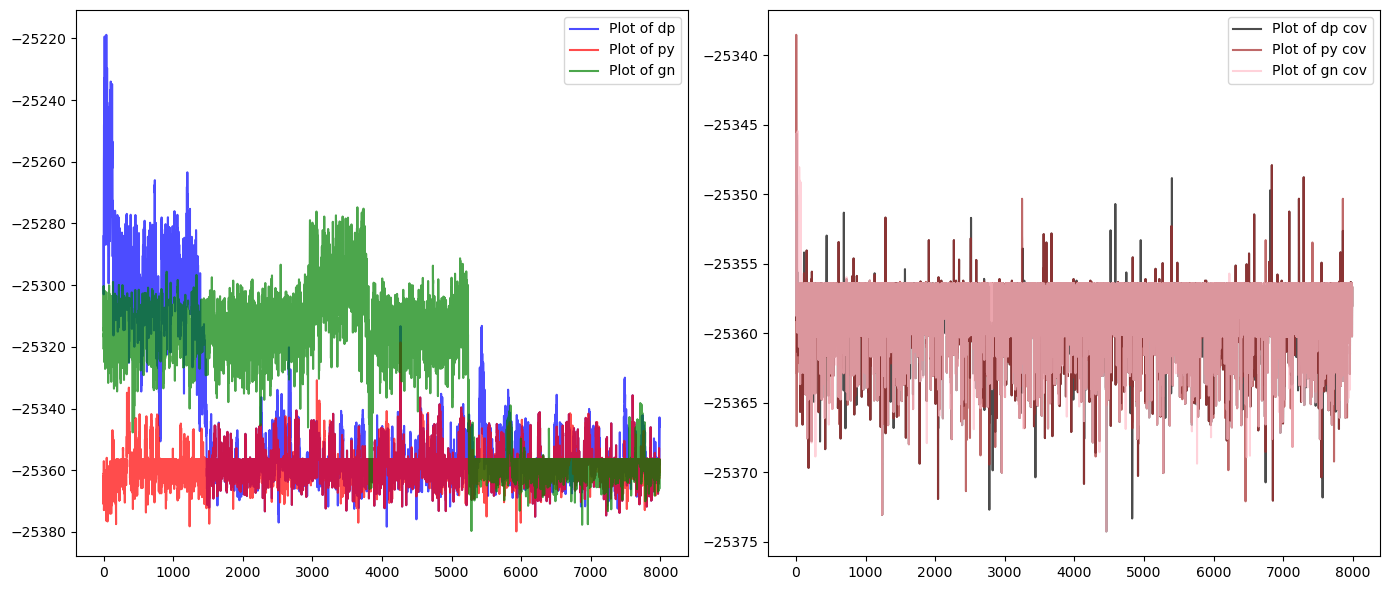

In [60]:
llk_dp = dp_model.train_llk
llk_py = py_model.train_llk
llk_gn = gn_model.train_llk

llk_dp_cov = dp_cov_model.train_llk
llk_py_cov = py_cov_model.train_llk
llk_gn_cov = gn_cov_model.train_llk

fig, ax1 = plt.subplots(1, 2, figsize=(14, 6))

ax1[0].plot(llk_dp[10:], color='blue', alpha=0.7, label='Plot of dp')
ax1[0].plot(llk_py[10:], color='red', alpha=0.7, label='Plot of py')
ax1[0].plot(llk_gn[10:], color='green', alpha=0.7, label='Plot of gn')
ax1[0].legend()

ax1[1].plot(llk_dp_cov[10:], color='black', alpha=0.7, label='Plot of dp cov')
ax1[1].plot(llk_py_cov[10:], color='brown', alpha=0.7, label='Plot of py cov')
ax1[1].plot(llk_gn_cov[10:], color='pink', alpha=0.7, label='Plot of gn cov')
ax1[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [61]:
vi_users_dp = dp_model.vi_users
vi_items_dp = dp_model.vi_items
vi_users_py = py_model.vi_users
vi_items_py = py_model.vi_items
vi_users_gn = gn_model.vi_users
vi_items_gn = gn_model.vi_items
vi_users_dp_cov = dp_cov_model.vi_users
vi_items_dp_cov = dp_cov_model.vi_items
vi_users_py_cov = py_cov_model.vi_users
vi_items_py_cov = py_cov_model.vi_items
vi_users_gn_cov = gn_cov_model.vi_users
vi_items_gn_cov = gn_cov_model.vi_items

mae_dp = dp_model.mae
mae_py = py_model.mae
mae_gn = gn_model.mae
mae_dp_cov = dp_cov_model.mae
mae_py_cov = py_cov_model.mae
mae_gn_cov = gn_cov_model.mae

mse_dp = dp_model.mse
mse_py = py_model.mse
mse_gn = gn_model.mse
mse_dp_cov = dp_cov_model.mse
mse_py_cov = py_cov_model.mse
mse_gn_cov = gn_cov_model.mse

waic_dp = dp_model.waic
waic_py = py_model.waic
waic_gn = gn_model.waic
waic_dp_cov = dp_cov_model.waic
waic_py_cov = py_cov_model.waic
waic_gn_cov = gn_cov_model.waic

precision_dp = dp_model.precision_ranks
precision_py = py_model.precision_ranks
precision_gn = gn_model.precision_ranks
precision_dp_cov = dp_cov_model.precision_ranks
precision_py_cov = py_cov_model.precision_ranks
precision_gn_cov = gn_cov_model.precision_ranks

recall_dp = dp_model.recall_ranks
recall_py = py_model.recall_ranks
recall_gn = gn_model.recall_ranks
recall_dp_cov = dp_cov_model.recall_ranks
recall_py_cov = py_cov_model.recall_ranks
recall_gn_cov = gn_cov_model.recall_ranks

In [62]:
output_table = pd.DataFrame()

output_table['VI users'] = [vi_users_dp, vi_users_py, vi_users_gn, vi_users_dp_cov, vi_users_py_cov, vi_users_gn_cov]
output_table['VI items'] = [vi_items_dp, vi_items_py, vi_items_gn, vi_items_dp_cov, vi_items_py_cov, vi_items_gn_cov]
output_table['MAE'] = [mae_dp, mae_py, mae_gn, mae_dp_cov, mae_py_cov, mae_gn_cov]
output_table['MSE'] = [mse_dp, mse_py, mse_gn, mse_dp_cov, mse_py_cov, mse_gn_cov]
output_table['WAIC'] = [waic_dp, waic_py, waic_gn, waic_dp_cov, waic_py_cov, waic_gn_cov]
output_table['Precision'] = [precision_dp, precision_py, precision_gn, precision_dp_cov, precision_py_cov, precision_gn_cov]
output_table['Recall'] = [recall_dp, recall_py, recall_gn, recall_dp_cov, recall_py_cov, recall_gn_cov]

output_table.index = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

output_table.round(3)

,VI users,VI items,MAE,MSE,WAIC,Precision,Recall
DP,0.0,0.064,0.488,0.521,None,0.154,0.308
PY,0.0,0.064,0.488,0.521,None,0.154,0.308
GN,0.0,0.064,0.488,0.521,None,0.154,0.308
DP_cov,0.0,0.139,0.488,0.521,None,0.154,0.308
PY_cov,0.0,0.139,0.488,0.521,None,0.154,0.308
GN_cov,0.0,0.139,0.488,0.521,None,0.154,0.308


### Not degree corrected model

In [63]:
params_baseline = {'scheme_type':'DP', 'cov_users':None,'cov_items':None, 'prior_a':1, 'prior_b':1, 'seed':42, 'scheme_param':1, 'bar_h_users':2, 'bar_h_items':3,
           'gamma':0.1, 'epsilon':1e-30, 'sigma':0.7, 'alpha_c':[1.5, 1.5, 1.5, 1.5], 'user_clustering':'random', 'item_clustering':'random'}

params_dp = params_baseline.copy()

params_dp['prior_a'] = 1
params_dp['prior_b'] = 1
params_dp['scheme_param'] = 2
params_dp['sigma'] = 0.329
params_dp['scheme_type'] = 'DP'

params_py = params_baseline.copy()
params_py['prior_a'] = 1
params_py['prior_b'] = 1
params_py['scheme_param'] = 1.3
params_py['sigma'] = 0.1
params_py['scheme_type'] = 'PY'

params_gn = params_baseline.copy()
params_gn['prior_a'] = 1
params_gn['prior_b'] = 1
params_gn['gamma'] = 0.55
params_gn['scheme_type'] = 'GN'

params_dp_cov = params_baseline.copy()
params_dp_cov['prior_a'] = 1
params_dp_cov['prior_b'] = 1
params_dp_cov['scheme_param'] = 2
params_dp_cov['cov_users'] = cov_users
params_dp_cov['cov_items'] = cov_items
params_dp_cov['scheme_type'] = 'DP'

params_py_cov = params_baseline.copy()
params_py_cov['prior_a'] = 1
params_py_cov['prior_b'] = 1
params_py_cov['scheme_param'] = 1.3
params_py_cov['sigma'] = 0.1
params_py_cov['cov_users'] = cov_users
params_py_cov['cov_items'] = cov_items
params_py_cov['scheme_type'] = 'PY'

params_gn_cov = params_baseline.copy()
params_gn_cov['prior_a'] = 1
params_gn_cov['prior_b'] = 1
params_gn_cov['gamma'] = 0.55
params_gn_cov['cov_users'] = cov_users
params_gn_cov['cov_items'] = cov_items
params_gn_cov['scheme_type'] = 'GN'

model_list = [Baseline, esbm, esbm, esbm, esbm , esbm, esbm]
params_list = [params_baseline, params_dp, params_py, params_gn, params_dp_cov, params_py_cov, params_gn_cov]
model_names = ['baseline', 'DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

In [64]:
out_models_esbm = validate_models(Y_train, Y_val, model_list, params_list, n_iters=n_iters, burn_in=burn_in,
                                 thinning=thinning, model_names=model_names, true_users=true_users, true_items=true_items,
                                 k=10, print_intermid=True)


Model name: baseline
initialsing user clusters random
initialising item clusters random
Starting training for model baseline
starting log likelihood -31000.018940985272
end llk:  -31000.018940985272
Starting waic computation baseline
Starting prediction for model baseline
Starting ranking for model baseline
MAE: 0.690125
MSE: 1.250875
Precision: 0.025824175824175826
Recall: 0.04483928769643056
VI users: 2.5142651052030978
VI items: 3.227928285556272

Model name: DP
initialsing user clusters random
initialising item clusters random
Starting training for model DP
starting log likelihood -31029.31441420403
end llk:  -25150.366113997963
Starting waic computation DP
Starting prediction for model DP
Starting ranking for model DP
MAE: 0.48566780227738765
MSE: 0.5156745706191311
Precision: 0.15714285714285714
Recall: 0.3194765551908409
VI users: 0.0
VI items: 0.0636010385085628

Model name: PY
initialsing user clusters random
initialising item clusters random
Starting training for model PY
st

In [65]:
baseline_model = out_models_esbm[0]
dp_model = out_models_esbm[1]
py_model = out_models_esbm[2]
gn_model = out_models_esbm[3]

dp_cov_model = out_models_esbm[4]
py_cov_model = out_models_esbm[5]
gn_cov_model = out_models_esbm[6]

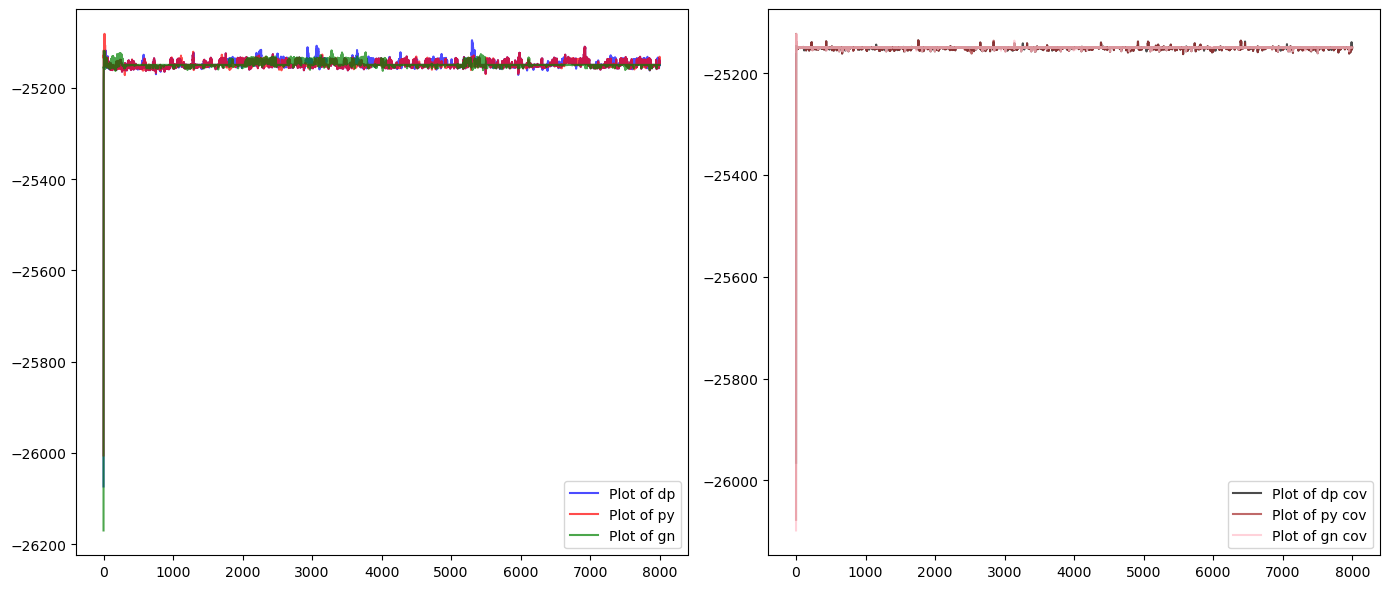

In [66]:
llk_dp = dp_model.train_llk
llk_py = py_model.train_llk
llk_gn = gn_model.train_llk

llk_dp_cov = dp_cov_model.train_llk
llk_py_cov = py_cov_model.train_llk
llk_gn_cov = gn_cov_model.train_llk

fig, ax1 = plt.subplots(1, 2, figsize=(14, 6))

ax1[0].plot(llk_dp[1:], color='blue', alpha=0.7, label='Plot of dp')
ax1[0].plot(llk_py[1:], color='red', alpha=0.7, label='Plot of py')
ax1[0].plot(llk_gn[1:], color='green', alpha=0.7, label='Plot of gn')
ax1[0].legend()

ax1[1].plot(llk_dp_cov[1:], color='black', alpha=0.7, label='Plot of dp cov')
ax1[1].plot(llk_py_cov[1:], color='brown', alpha=0.7, label='Plot of py cov')
ax1[1].plot(llk_gn_cov[1:], color='pink', alpha=0.7, label='Plot of gn cov')
ax1[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [67]:
vi_users_dp = dp_model.vi_users
vi_items_dp = dp_model.vi_items
vi_users_py = py_model.vi_users
vi_items_py = py_model.vi_items
vi_users_gn = gn_model.vi_users
vi_items_gn = gn_model.vi_items
vi_users_dp_cov = dp_cov_model.vi_users
vi_items_dp_cov = dp_cov_model.vi_items
vi_users_py_cov = py_cov_model.vi_users
vi_items_py_cov = py_cov_model.vi_items
vi_users_gn_cov = gn_cov_model.vi_users
vi_items_gn_cov = gn_cov_model.vi_items

mae_dp = dp_model.mae
mae_py = py_model.mae
mae_gn = gn_model.mae
mae_dp_cov = dp_cov_model.mae
mae_py_cov = py_cov_model.mae
mae_gn_cov = gn_cov_model.mae

mse_dp = dp_model.mse
mse_py = py_model.mse
mse_gn = gn_model.mse
mse_dp_cov = dp_cov_model.mse
mse_py_cov = py_cov_model.mse
mse_gn_cov = gn_cov_model.mse

waic_dp = dp_model.waic
waic_py = py_model.waic
waic_gn = gn_model.waic
waic_dp_cov = dp_cov_model.waic
waic_py_cov = py_cov_model.waic
waic_gn_cov = gn_cov_model.waic

precision_dp = dp_model.precision_ranks
precision_py = py_model.precision_ranks
precision_gn = gn_model.precision_ranks
precision_dp_cov = dp_cov_model.precision_ranks
precision_py_cov = py_cov_model.precision_ranks
precision_gn_cov = gn_cov_model.precision_ranks

recall_dp = dp_model.recall_ranks
recall_py = py_model.recall_ranks
recall_gn = gn_model.recall_ranks
recall_dp_cov = dp_cov_model.recall_ranks
recall_py_cov = py_cov_model.recall_ranks
recall_gn_cov = gn_cov_model.recall_ranks

In [68]:
output_table2 = pd.DataFrame()

output_table2['VI users'] = [vi_users_dp, vi_users_py, vi_users_gn, vi_users_dp_cov, vi_users_py_cov, vi_users_gn_cov]
output_table2['VI items'] = [vi_items_dp, vi_items_py, vi_items_gn, vi_items_dp_cov, vi_items_py_cov, vi_items_gn_cov]
output_table2['MAE'] = [mae_dp, mae_py, mae_gn, mae_dp_cov, mae_py_cov, mae_gn_cov]
output_table2['MSE'] = [mse_dp, mse_py, mse_gn, mse_dp_cov, mse_py_cov, mse_gn_cov]
output_table2['WAIC'] = [waic_dp, waic_py, waic_gn, waic_dp_cov, waic_py_cov, waic_gn_cov]
output_table2['Precision'] = [precision_dp, precision_py, precision_gn, precision_dp_cov, precision_py_cov, precision_gn_cov]
output_table2['Recall'] = [recall_dp, recall_py, recall_gn, recall_dp_cov, recall_py_cov, recall_gn_cov]

output_table2.index = ['DP', 'PY', 'GN', 'DP_cov', 'PY_cov', 'GN_cov']

output_table2.round(3)

,VI users,VI items,MAE,MSE,WAIC,Precision,Recall
DP,0.0,0.064,0.486,0.516,None,0.157,0.319
PY,0.0,0.064,0.486,0.516,None,0.157,0.319
GN,0.0,0.064,0.486,0.516,None,0.157,0.319
DP_cov,0.0,0.064,0.486,0.516,None,0.157,0.319
PY_cov,0.0,0.064,0.486,0.516,None,0.157,0.319
GN_cov,0.0,0.064,0.486,0.516,None,0.157,0.319


In [69]:
output_table.round(3)

,VI users,VI items,MAE,MSE,WAIC,Precision,Recall
DP,0.0,0.064,0.488,0.521,None,0.154,0.308
PY,0.0,0.064,0.488,0.521,None,0.154,0.308
GN,0.0,0.064,0.488,0.521,None,0.154,0.308
DP_cov,0.0,0.139,0.488,0.521,None,0.154,0.308
PY_cov,0.0,0.139,0.488,0.521,None,0.154,0.308
GN_cov,0.0,0.139,0.488,0.521,None,0.154,0.308
